# Part 2 - Looking at timeframes of project approvals
- OMG pls work. The idea is to create a machine learning model that will predict how long your approval will take.

In [1700]:
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [1701]:
# define file locations
# approved construction permits
alvaras_file = 'C:/Users/Zaca/Documents/Datasets/lisbon/alvaras/alvaras.shp'

# all processes?
processos_file = 'C:/Users/Zaca/Documents/Datasets/lisbon/alvaras/processos.shp'


alvaras = gp.read_file(alvaras_file)
alvaras['DATA_ENTRA'] = pd.to_datetime(alvaras['DATA_ENTRA'])
alvaras['DATA_ALVAR'] = pd.to_datetime(alvaras['DATA_ALVAR'])
alvaras['DEMORA'] = (alvaras['DATA_ALVAR'] - alvaras['DATA_ENTRA']).dt.days
alvaras = alvaras[alvaras['DATA_ENTRA'] >= '2009-01-01']

alvaras['WEEKDAY'] = [x.weekday() for x in alvaras['DATA_ENTRA']]
alvaras['MONTH'] = alvaras['DATA_ENTRA'].dt.month
alvaras['YEAR'] = alvaras['DATA_ENTRA'].dt.year

In [1702]:
Q1 = alvaras['DEMORA'].quantile(0.25)
Q3 = alvaras['DEMORA'].quantile(0.75)
IQR = Q3 - Q1
alvaras = alvaras[(alvaras['DEMORA'] > (Q1 - 1.5 * IQR)) & (alvaras['DEMORA'] < (Q3 + 1.5 * IQR))]

In [1703]:
alvaras['ASSUNTO'].fillna('Not specified', inplace=True)

In [1704]:
processos = gp.read_file(processos_file)
processos['DATA_ENTRA'] = pd.to_datetime(processos['DATA_ENTRA'])
processos = processos[processos['FREGUESIA'] != 'Lumiar (Extinta)']

In [1705]:
def into_timeseries(df, dt_col):
    df = df.set_index(dt_col)
    df.index = pd.to_datetime(df.index)
    return df

processos_ts = into_timeseries(processos, 'DATA_ENTRA')

In [1706]:
process_count = processos_ts.resample('MS').count()['OBJECTID'].reset_index()
process_count['STRING_DATE'] = process_count['DATA_ENTRA'].astype('str').str[:-3]
process_count_dict = pd.Series(process_count['OBJECTID'].values, index=process_count['STRING_DATE']).to_dict()

In [1707]:
alvaras['DATA'] = alvaras['DATA_ENTRA'].astype('str').str[:-3]
alvaras['COUNT'] = alvaras['DATA'].map(process_count_dict)

In [1708]:
grouper = processos_ts.groupby([pd.Grouper(freq='MS'), 'FREGUESIA'])
result = grouper['OBJECTID'].count().unstack('FREGUESIA').fillna(0).reset_index()
result['STRING_DATE'] = result['DATA_ENTRA'].astype('str').str[:-3]

In [1709]:
freguesias = alvaras['FREGUESIA'].value_counts().index.to_list()

In [1710]:
for col in freguesias:
    map_dict = pd.Series(result[col].values, index=result['STRING_DATE']).to_dict()
    alvaras[col] = np.where((alvaras['FREGUESIA'] == col), alvaras['DATA'].map(map_dict), 0)

In [1711]:
alvaras['SUBCOUNT'] = alvaras[freguesias].sum(axis=1)
alvaras.drop(labels=freguesias, inplace=True, axis=1)

In [1712]:
alvaras

,OBJECTID,COD_SIG,IDTIPO,N_PROCESSO,DATA_ENTRA,TIPOLOGIA,MORADA,FREGUESIA,OP_URBANIS,ASSUNTO,...,Shape__Are,Shape__Len,geometry,DEMORA,WEEKDAY,MONTH,YEAR,DATA,COUNT,SUBCOUNT
2,13,3100404009001,2,852/EDI/2009,2009-06-19,Edificação,R do Jardim do Regedor 10-32,Santa Maria Maior,Ampliação,Not specified,...,662.744629,107.992681,"POLYGON ((-9.14066 38.71559, -9.14067 38.71560...",502,4,6,2009,2009-06,180,13.0
3,14,4402803033001,2,852/EDI/2010,2010-08-11,Edificação,R Passos Manuel 19-,Arroios,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,554.964355,94.524498,"POLYGON ((-9.13697 38.72794, -9.13696 38.72779...",285,2,8,2010,2010-08,109,19.0
4,15,0100901028001,2,852/EDI/2011,2011-08-16,Edificação,Estr da Cruz 30,Ajuda,Construção,Not specified,...,296.551758,69.374560,"POLYGON ((-9.20697 38.71090, -9.20701 38.71086...",127,1,8,2011,2011-08,126,5.0
5,16,3800804006001,2,852/EDI/2012,2012-08-31,Edificação,R da Madalena 182-182C,Santa Maria Maior,Alteração,Alterações Interiores,...,183.309570,61.931927,"POLYGON ((-9.13619 38.71280, -9.13611 38.71280...",633,4,8,2012,2012-08,120,12.0
6,17,1601502036001,2,852/EDI/2014,2014-07-28,Edificação,Cc do Monte 70-72A,São Vicente,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,320.532227,77.226981,"POLYGON ((-9.13118 38.71846, -9.13125 38.71838...",533,0,7,2014,2014-07,176,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,21705,2107401104001,2,761/EDI/2012,2012-08-03,Edificação,Av Infante Dom Henrique Lote 310,Marvila,Alteração,Alterações Exteriores,...,3001.556152,247.560794,"POLYGON ((-9.10309 38.75256, -9.10307 38.75260...",291,4,8,2012,2012-08,120,2.0
9324,21706,2601305004001,2,761/EDI/2013,2013-07-15,Edificação,R do Prior 3,Estrela,Ampliação,Not specified,...,232.627930,65.531750,"POLYGON ((-9.16175 38.70691, -9.16164 38.70693...",897,0,7,2013,2013-07,147,10.0
9326,21723,0702507045001,2,772/EDI/2013,2013-07-17,Edificação,R Dom Francisco D`Eça 54,Beato,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,80.615723,40.684366,"POLYGON ((-9.11197 38.73243, -9.11183 38.73244...",110,2,7,2013,2013-07,147,3.0
9327,21724,2201303046001,2,772/EDI/2014,2014-07-14,Edificação,R da Cruz dos Poiais 38-38A,Misericórdia,Alteração Durante a Execução da Obra,Alteração ao projecto de arquitectura,...,90.650391,43.103383,"POLYGON ((-9.15152 38.71164, -9.15150 38.71168...",31,0,7,2014,2014-07,176,22.0


In [1713]:
alvaras.dropna(inplace=True)

In [1714]:
cols = ['FREGUESIA', 'OP_URBANIS', 'PROCEDIMEN', 'ASSUNTO', 'TIPO_ALVAR', 'COUNT', 'SUBCOUNT', 'Shape__Are', 'MONTH', 'YEAR', 'DEMORA']
alvaras_ml = alvaras[cols]
cat = ['FREGUESIA', 'OP_URBANIS', 'PROCEDIMEN', 'TIPO_ALVAR', 'ASSUNTO']

In [1715]:
for col in cat:
    alvaras_ml[col] = le.fit_transform(alvaras_ml[col].astype(str))

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1716]:
alvaras_ml

,FREGUESIA,OP_URBANIS,PROCEDIMEN,ASSUNTO,TIPO_ALVAR,COUNT,SUBCOUNT,Shape__Are,MONTH,YEAR,DEMORA
2,20,3,2,7,9,180,13.0,662.744629,6,2009,502
3,4,1,2,1,0,109,19.0,554.964355,8,2010,285
4,0,4,1,7,7,126,5.0,296.551758,8,2011,127
5,20,0,2,3,9,120,12.0,183.309570,8,2012,633
6,23,1,2,1,0,176,9.0,320.532227,7,2014,533
...,...,...,...,...,...,...,...,...,...,...,...
9323,14,0,1,2,7,120,2.0,3001.556152,8,2012,291
9324,12,3,2,7,9,147,10.0,232.627930,7,2013,897
9326,6,1,1,1,0,147,3.0,80.615723,7,2013,110
9327,15,1,1,1,7,176,22.0,90.650391,7,2014,31


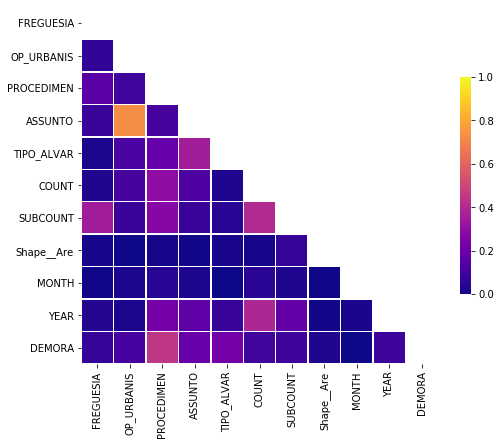

In [1717]:
# now every data is numerical I will compute the correlation matrix to remove colinearity features
corr = alvaras_ml.corr().abs()

# make a heatmap
f, ax = plt.subplots(figsize=(8, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='plasma', vmin=0, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [1718]:
X = alvaras_ml.drop('DEMORA', axis=1)
y = alvaras_ml['DEMORA']

In [1719]:
# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [1720]:
# make the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1721]:
# initialize linear regression model
lr = LinearRegression()

# fit training data
model = lr.fit(X_train, y_train)

In [1722]:
# get score
model.score(X_test, y_test)

0.2245930382035879

In [1723]:
from sklearn.metrics import mean_squared_error, r2_score

def create_polynomial_regression_model(degree):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    poly_features = PolynomialFeatures(degree=degree)
  
  # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
  
  # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)
  
  # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)
  
    print("The model performance for the training set")
    print("-------------------------------------------")
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
  
    print("\n")
  
    print("The model performance for the test set")
    print("-------------------------------------------")
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))

In [1729]:
create_polynomial_regression_model(2)

The model performance for the training set
-------------------------------------------
RMSE of training set is 253.76149693939934
R2 score of training set is 0.27491373062919444


The model performance for the test set
-------------------------------------------
RMSE of test set is 259.6257955800476
R2 score of test set is 0.25987775034176264


In [1725]:
# Create interaction term (not polynomial features)
poly_model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model = poly_model.fit(X_train, y_train)
poly_model.score(X_test, y_test)

-42777058.156839445

In [1726]:
# random forest regression
for i in range(1, 15):
    rfr = RandomForestRegressor(max_depth=i, random_state=42)
    rfr.fit(X_train, y_train)
    score = rfr.score(X_test, y_test)
    print(i, score)

1 0.1929256142265089
2 0.23169586572423406
3 0.2574581408784047
4 0.2727153862577394
5 0.2896203613653727
6 0.30254006375044423
7 0.30785023665602407
8 0.3086431339557941
9 0.3092761977710512
10 0.3082855625223787
11 0.3060198539621858
12 0.30024895702554033
13 0.2997119953388494
14 0.29623828406407704


In [1727]:
from sklearn.metrics import mean_absolute_error
rfr = RandomForestRegressor(max_depth=8, random_state=42)
rfr.fit(X_train, y_train)
score = rfr.score(X_train, y_train)
print('Train score:', score)
score = rfr.score(X_test, y_test)
print('Test score:', score)

y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
mse_train = mean_absolute_error(y_train, y_pred_train)
mse_test = mean_absolute_error(y_test, y_pred_test)

print('mae train', mse_train)
print('mae test', mse_test)

Train score: 0.4123801812086707
Test score: 0.3086431339557941
mae train 172.1450089552185
mae test 191.42608585795705


In [1728]:
from sklearn.model_selection import cross_val_score

# cross validate the results of the random forest regressor
cv_rfr = cross_val_score(rfr, X, y, cv=10)
cv_rfr

array([0.33688556, 0.26647227, 0.33931907, 0.29857682, 0.25786412,
       0.2314388 , 0.32501415, 0.32142968, 0.33021478, 0.2766601 ])